# Preprocessing

## Installing Libraries

In [1]:
import torch
import pandas as pd
import numpy as np
from underthesea import sent_tokenize, word_tokenize, text_normalize
import emoji
from vncorenlp import VnCoreNLP
import collections
import emoji_vietnamese as ev
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import re

/Users/binhtran/personal-projects/llm-data-aug/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pre-process the translated data

In [2]:
# Data after translation and pre-process
# Only keep 2 cols: review and sentiment
df = pd.read_csv("/Users/binhtran/personal-projects/llm-data-aug/data/translated_user_reviews.csv")
df

,Review,Sentiment
0,Rất cơ bản.,Positive
1,Họ đã miễn phí thịt xông khói thịt lợn trong s...,Neutral
2,"Trong McDonald's, họ cho tóc ăn.",Negative
3,khó đặt hàng,Positive
4,"Đẳng cấp hơn các loại gà rán khác, cảm giác đa...",Positive
...,...,...
2678,Tôi đặt hàng từ McDonalds khá thường xuyên sử ...,Neutral
2679,OK... điểm hẹn lý tưởng cuối tuần cho các bé,Positive
2680,Tuyệt vời khi đi bạn bè đông,Positive
2681,Nhà hàng MC Donald được mở đầu tiên,Neutral


In [3]:
duplicate_rows = df[df.duplicated()]
duplicate_rows

,Review,Sentiment
195,Thức ăn ngon,Positive
258,Đẹp,Positive
308,Tốt,Positive
310,Tốt,Positive
311,Tốt,Positive
...,...,...
2663,Thơm ngon,Positive
2668,Tuyệt,Positive
2670,Được rồi,Positive
2673,Được rồi,Neutral


In [4]:
# Drop duplicates in place, keeping the first occurrence
df.drop_duplicates(inplace=True)
df

,Review,Sentiment
0,Rất cơ bản.,Positive
1,Họ đã miễn phí thịt xông khói thịt lợn trong s...,Neutral
2,"Trong McDonald's, họ cho tóc ăn.",Negative
3,khó đặt hàng,Positive
4,"Đẳng cấp hơn các loại gà rán khác, cảm giác đa...",Positive
...,...,...
2677,Buổi trưa ngồi bị hắt nắng,Positive
2678,Tôi đặt hàng từ McDonalds khá thường xuyên sử ...,Neutral
2679,OK... điểm hẹn lý tưởng cuối tuần cho các bé,Positive
2680,Tuyệt vời khi đi bạn bè đông,Positive


In [5]:
# Hàm normalize_repeated_words
def normalize_repeated_words(text):
    # Sử dụng biểu thức chính quy để tìm và thay thế các từ viết kéo dài
    normalized_text = re.sub(r'(\w)(\1{2,})', r'\1', text)
    return normalized_text

# Hàm remove_non_alphanumeric
def remove_non_alphanumeric(string):
    allowed_characters = r'[^\w\sA-Za-zÀÁẮẤẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴa-z0-9.,\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF.]+'
    return re.sub(allowed_characters, '', string)

# Hàm xử lý các ký tự đặc biệt
def remove_special_characters(text):
    special_characters = r'[\x00-\x1F\x7F' + \
                         r'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' + \
                         r'¢£¥€©®™“”‘’–\/‒—ñàáâäçßæøÿ]'
    clean_text = re.sub(r'\.\.\.', '...', str(text))
    clean_text = re.sub(special_characters, '', clean_text)
    return clean_text

# Hàm build_dictionary_from_file
def build_dictionary_from_file(file_path):
    abbreviation_dict = {}

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split(',')
                if len(parts) == 2:
                    abbreviation, full_form = map(str.strip, parts)
                    abbreviation_dict[abbreviation] = full_form

    return abbreviation_dict

# Function to expand abbreviations in a given text
def expand_abbr(text, abbr_dict):
    return ' '.join(abbr_dict.get(word, word) for word in text.split())

# Đường dẫn đến tệp chứa danh sách các từ viết tắt và định nghĩa tương ứng
abbreviations_path = ("/Users/binhtran/personal-projects/llm-data-aug/data/abbreviate.txt")
abbr = build_dictionary_from_file(abbreviations_path)

# Initialize VnCoreNLP
vncorenlp_path = '/Users/binhtran/personal-projects/llm-data-aug/notebooks/VnCoreNLP/VnCoreNLP-1.2.jar'  # Thay đường dẫn đến VnCoreNLP.jar tại đây
vncorenlp = VnCoreNLP(vncorenlp_path)

# Tokenize text in each row of the DataFrame
def tokenize_text(text):
    tokens = vncorenlp.tokenize(text)
    return ' '.join(' '.join(sentence) for sentence in tokens)

# Apply preprocessing functions to the 'review' column
df['Review'] = df['Review'].apply(str.lower)  # Chuyển đổi văn bản thành chữ thường trước khi xử lý
df['Review'] = df['Review'].apply(remove_non_alphanumeric)
df['Review'] = df['Review'].apply(lambda x: expand_abbr(x, abbr))
df['Review'] = df['Review'].apply(remove_special_characters)
df['Review'] = df['Review'].apply(normalize_repeated_words)
df['tokenized_text'] = df['Review'].apply(tokenize_text)

# Hiển thị dữ liệu trong cột 'tokenized_text' dưới dạng câu thông thường
print(df['tokenized_text'])

0                                            rất cơ_bản .
1       họ đã miễn_phí thịt xông khói thịt lợn trong s...
2                       trong mcdonalds , họ cho tóc ăn .
3                                            khó đặt_hàng
4       đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...
                              ...                        
2677                           buổi trưa ngồi bị hắt nắng
2678    tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...
2679        ok ... điểm hẹn lý_tưởng cuối tuần cho các bé
2680                         tuyệt_vời khi đi bạn_bè đông
2681                  nhà_hàng mc donald được mở đầu tiên
Name: tokenized_text, Length: 2378, dtype: object


In [6]:
get_emoji = lambda review_column: collections.Counter([match["emoji"] for review in review_column for match in emoji.emoji_list(review)])

df['emoji to text'] = df['tokenized_text'].apply(ev.demojize)
df.head()

,Review,Sentiment,tokenized_text,emoji to text
0,rất cơ bản.,Positive,rất cơ_bản .,rất cơ_bản .
1,họ đã miễn phí thịt xông khói thịt lợn trong s...,Neutral,họ đã miễn_phí thịt xông khói thịt lợn trong s...,họ đã miễn_phí thịt xông khói thịt lợn trong s...
2,"trong mcdonalds, họ cho tóc ăn.",Negative,"trong mcdonalds , họ cho tóc ăn .","trong mcdonalds , họ cho tóc ăn ."
3,khó đặt hàng,Positive,khó đặt_hàng,khó đặt_hàng
4,"đẳng cấp hơn các loại gà rán khác, cảm giác đa...",Positive,"đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...","đẳng_cấp hơn các loại gà rán khác , cảm_giác đ..."


In [7]:
emojis_count = get_emoji(df['tokenized_text'])
print(emojis_count)

Counter({'👍': 22, '😂': 14, '🍔': 9, '😅': 8, '😭': 6, '🌟': 5, '🍦': 5, '🍗': 5, '🍕': 5, '😁': 4, '💯': 4, '😍': 4, '😗': 3, '😔': 3, '👌': 3, '💚': 3, '😬': 3, '🍟': 3, '🎵': 2, '😀': 2, '😳': 2, '😢': 2, '💑': 1, '😆': 1, '😊': 1, '💫': 1, '🎶': 1, '👌🏼': 1, '😠': 1, '😡': 1, '🙂': 1, '🔴': 1, '📍': 1, '💲': 1, '😚': 1, '😌': 1, '👏': 1, '😕': 1, '👎': 1, '🙄': 1, '💋': 1, '😄': 1, '😏': 1, '🚗': 1, '🏻': 1, '💜': 1, '👩': 1, '💨': 1, '🙃': 1, '👍🏻': 1})


In [8]:
# Đọc danh sách stop words từ file vietnamese_stopword.txt
with open('/Users/binhtran/personal-projects/llm-data-aug/data/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    stop_words = set([word.strip() for word in file.readlines()])
# Hàm để loại bỏ stop words
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Áp dụng hàm loại bỏ stop words vào cột text của dataframe
df['emoji to text + stopwords'] = df['emoji to text'].apply(remove_stopwords)
df.head()

,Review,Sentiment,tokenized_text,emoji to text,emoji to text + stopwords
0,rất cơ bản.,Positive,rất cơ_bản .,rất cơ_bản .,cơ_bản
1,họ đã miễn phí thịt xông khói thịt lợn trong s...,Neutral,họ đã miễn_phí thịt xông khói thịt lợn trong s...,họ đã miễn_phí thịt xông khói thịt lợn trong s...,miễn_phí thịt xông khói thịt lợn salad hồi_giá...
2,"trong mcdonalds, họ cho tóc ăn.",Negative,"trong mcdonalds , họ cho tóc ăn .","trong mcdonalds , họ cho tóc ăn .",mcdonalds tóc
3,khó đặt hàng,Positive,khó đặt_hàng,khó đặt_hàng,đặt_hàng
4,"đẳng cấp hơn các loại gà rán khác, cảm giác đa...",Positive,"đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...","đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...",đẳng_cấp gà rán mỹ vn 2200 đông ..


In [9]:
# Save the cleaned data

# The data has been through the following steps:
# 1. Remove non-alphanumeric characters
# 2. Expand abbreviations
# 3. Remove special characters
# 4. Normalize repeated words
# 5. Tokenize the text
# 6. Remove stop words

df.to_csv("/Users/binhtran/personal-projects/llm-data-aug/data/cleaned_user_reviews.csv", index=False)


## WORD CLOUD

In [10]:
from wordcloud import WordCloud
from underthesea import pos_tag

In [11]:
# Lọc dữ liệu để chỉ lấy những hàng có label = 1
filtered_data = df[df["Sentiment"] == "Positive"]

# In ra dữ liệu đã lọc
print(filtered_data)

                                                 Review Sentiment  \
0                                           rất cơ bản.  Positive   
3                                          khó đặt hàng  Positive   
4     đẳng cấp hơn các loại gà rán khác, cảm giác đa...  Positive   
6     ngay cả khi có một chút rào cản ngôn ngữ, chún...  Positive   
9                                          thức ăn ngon  Positive   
...                                                 ...       ...   
2672                              thức ăn ngon, nơi tốt  Positive   
2674                           ngon hơn kfc và lotteria  Positive   
2677                         buổi trưa ngồi bị hắt nắng  Positive   
2679       ok... điểm hẹn lý tưởng cuối tuần cho các bé  Positive   
2680                       tuyệt vời khi đi bạn bè đông  Positive   

                                         tokenized_text  \
0                                          rất cơ_bản .   
3                                          khó đặt_hà

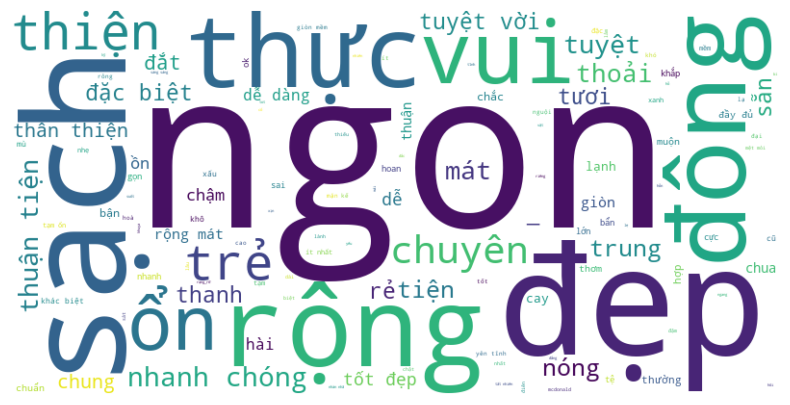

In [12]:
# Hàm để gán nhãn từ loại cho mỗi văn bản và lọc ra các tính từ
def get_adjectives(text):
    tokens = vncorenlp.pos_tag(text)
    adjectives = []
    for sentence in tokens:
        for word, tag in sentence:
            if tag and tag.startswith('A'):
                adjectives.append(word)
    return adjectives



# Lấy cột 'emoji to text + stopwords' từ dữ liệu
texts = filtered_data['emoji to text + stopwords'].tolist()

# Khởi tạo danh sách để lưu các tính từ
adjectives = []

# Gán nhãn từ loại và lọc ra các tính từ từ mỗi văn bản
for text in texts:
    adjectives.extend(get_adjectives(text))

# Chuyển danh sách tính từ thành chuỗi
adjectives_text = ' '.join(adjectives)

# Tạo WordCloud từ danh sách các từ tính từ
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(adjectives_text)

# Hiển thị WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

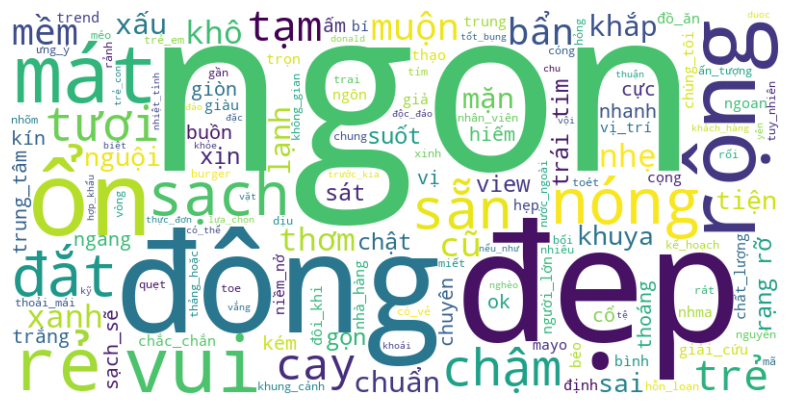

In [13]:
# Lấy cột text từ dữ liệu
texts = filtered_data['emoji to text + stopwords'].tolist()
# Khởi tạo danh sách để lưu các tính từ
adjectives = []

# POS tagging và lọc các tính từ
for text in texts:
    pos_tags = pos_tag(text)
    for word, pos in pos_tags:
        if pos.startswith('A'):  # Tính từ
            adjectives.append(word)

# Chuyển danh sách tính từ thành chuỗi
adjectives_text = ' '.join(adjectives)

# Tạo wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(adjectives_text)

# Hiển thị wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Topic Modeling with BERTopic

In [14]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

df = df.reset_index(drop=True)
# Lấy cột text từ dữ liệu
docs = df['emoji to text + stopwords']

# Khởi tạo mô hình biểu diễn câu tiếng Việt
sentence_model = SentenceTransformer("keepitreal/vietnamese-sbert")

# Biểu diễn các văn bản thành vectơ
sentence_embeddings = sentence_model.encode(docs, show_progress_bar=True)

# Khởi tạo và fit model BERTopic cho tiếng Việt
topic_model = BERTopic(language="vietnamese")
topics, probs = topic_model.fit_transform(docs, sentence_embeddings)

# In ra các chủ đề được phát hiện
print("Các chủ đề được phát hiện:")
print(topic_model.get_topics())

Batches: 100%|██████████| 75/75 [00:06<00:00, 11.07it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Các chủ đề được phát hiện:
{-1: [('đồ_ăn', np.float64(0.014557275507165485)), ('nhân_viên', np.float64(0.013398030030365103)), ('thức_ăn', np.float64(0.011515286336330949)), ('ngon', np.float64(0.011451837526623699)), ('phục_vụ', np.float64(0.011373484168534358)), ('món', np.float64(0.011299363944132678)), ('việt_nam', np.float64(0.011207626041322239)), ('nhà_hàng', np.float64(0.010978413644477875)), ('mcdonalds', np.float64(0.010343226529687248)), ('có_thể', np.float64(0.01032143086114472))], 0: [('gà', np.float64(0.06262243386149755)), ('rán', np.float64(0.03251257644547604)), ('miếng', np.float64(0.020448870164633693)), ('giòn', np.float64(0.01832996174005934)), ('ngon', np.float64(0.017752754440423457)), ('sốt', np.float64(0.01757195039917273)), ('chiên', np.float64(0.016909797812005387)), ('khoai_tây', np.float64(0.016485786749431647)), ('chấm', np.float64(0.014626617962517996)), ('thịt', np.float64(0.014510075805352957))], 1: [('mát', np.float64(0.11204038043457976)), ('thoáng', 

In [15]:
topic_labels = topic_model.generate_topic_labels(nr_words=2, separator=", ")
topic_labels

['-1, đồ_ăn, nhân_viên',
 '0, gà, rán',
 '1, mát, thoáng',
 '2, nhân_viên, thái_độ',
 '3, xe, đậu',
 '4, đông, quán',
 '5, nhà_vệ_sinh, mùi',
 '6, mcdonald, mcspicy',
 '7, burger, bánh',
 '8, order, thanh_toán',
 '9, đồ, ',
 '10, tuyệt_vời, tuyệt',
 '11, bình_thường, tạm',
 '12, cà_phê, uống',
 '13, chuyên_nghiệp, chờ_đợi',
 '14, chúng_tôi, đặt_hàng',
 '15, ok, te',
 '16, rẻ, giá',
 '17, đông, vui',
 '18, dịch_vụ, nhanh_chóng',
 '19, ngon, nga',
 '20, sạch_sẽ, lịch_sự',
 '21, mcdonalds, tất_cả',
 '22, kem, tươi',
 '23, co, va',
 '24, mcdonald, sốt',
 '25, đồ_ăn, view',
 '26, thức_ăn, dịch_vụ',
 '27, thích, mặt',
 '28, hà_nội, duy_nhất',
 '29, thân_thiện, nhân_viên',
 '30, hà_nội, duy_nhất',
 '31, thức_ăn, mặt_tiền',
 '32, mac, big',
 '33, khoai_tây, chiên',
 '34, ngon, an',
 '35, hồ, gươm',
 '36, ổn, liệu',
 '37, tương_ớt, sốt',
 '38, trẻ_em, đồ_chơi',
 '39, xe, bãi',
 '40, bánh_mì, kẹp',
 '41, hamburger, muộn',
 '42, quán, đồ_ăn',
 '43, đẹp, nhắm',
 '44, 24, 2424',
 '45, , ',
 '46, đô

# Detect sentiment using pretrain model

In [16]:
from transformers import RobertaForSequenceClassification

In [17]:
model = RobertaForSequenceClassification.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")

tokenizer = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment", use_fast=False)

In [18]:
# Function to detect sentiment using PhoBERT
def detect_sentiment(text):
    # Truncate the input text to a maximum length of 256 tokens
    truncated_text = tokenizer.encode(text, max_length=256, truncation=True)
    input_ids = torch.tensor([truncated_text])

    with torch.no_grad():
        output = model(input_ids)
        probabilities = output.logits.softmax(dim=-1).tolist()[0]
        sentiment_label = ["Negative", "Positive", "Neutral"][probabilities.index(max(probabilities))]
        return sentiment_label

# Apply sentiment detection to the 'emoji_text' column
df['SentimentBERT'] = df['emoji to text'].apply(detect_sentiment)

In [19]:
df

,Review,Sentiment,tokenized_text,emoji to text,emoji to text + stopwords,SentimentBERT
0,rất cơ bản.,Positive,rất cơ_bản .,rất cơ_bản .,cơ_bản,Positive
1,họ đã miễn phí thịt xông khói thịt lợn trong s...,Neutral,họ đã miễn_phí thịt xông khói thịt lợn trong s...,họ đã miễn_phí thịt xông khói thịt lợn trong s...,miễn_phí thịt xông khói thịt lợn salad hồi_giá...,Positive
2,"trong mcdonalds, họ cho tóc ăn.",Negative,"trong mcdonalds , họ cho tóc ăn .","trong mcdonalds , họ cho tóc ăn .",mcdonalds tóc,Neutral
3,khó đặt hàng,Positive,khó đặt_hàng,khó đặt_hàng,đặt_hàng,Negative
4,"đẳng cấp hơn các loại gà rán khác, cảm giác đa...",Positive,"đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...","đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...",đẳng_cấp gà rán mỹ vn 2200 đông ..,Positive
...,...,...,...,...,...,...
2373,buổi trưa ngồi bị hắt nắng,Positive,buổi trưa ngồi bị hắt nắng,buổi trưa ngồi bị hắt nắng,trưa hắt nắng,Negative
2374,tôi đặt hàng từ mcdonalds khá thường xuyên sử ...,Neutral,tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...,tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...,đặt_hàng mcdonalds thường_xuyên sử_dụng ứng_dụ...,Positive
2375,ok... điểm hẹn lý tưởng cuối tuần cho các bé,Positive,ok ... điểm hẹn lý_tưởng cuối tuần cho các bé,ok ... điểm hẹn lý_tưởng cuối tuần cho các bé,ok ... hẹn lý_tưởng bé,Positive
2376,tuyệt vời khi đi bạn bè đông,Positive,tuyệt_vời khi đi bạn_bè đông,tuyệt_vời khi đi bạn_bè đông,tuyệt_vời bạn_bè đông,Positive


## Corrected Label

In [20]:
import io
import pandas as pd

# Essentially copying the Bert sentiment labels to the sentiment column

newsent= pd.read_csv(io.StringIO('''
1,Positive
2,Negative
3,Negative
5,Negative
7,Negative
10,Negative
11,Negative
15,Negative
17,Negative
18,Negative
19,Negative
22,Negative
24,Negative
34,Negative
37,Positive
48,Negative
57,Positive
58,Positive
60,Positive
62,Positive
67,Positive
68,Negative
70,Negative
72,Positive
77,Positive
78,Positive
80,Negative
82,Positive
84,Positive
90,Negative
107,Negative
108,Negative
113,Positive
117,Negative
130,Positive
136,Negative
141,Negative
146,Negative
150,Positive
151,Negative
152,Positive
156,Positive
162,Negative
165,Positive
168,Negative
172,Positive
178,Negative
181,Positive
189,Negative
191,Positive
193,Positive
201,Positive
209,Negative
214,Positive
218,Positive
219,Positive
225,Negative
229,Positive
232,Negative
243,Positive
245,Negative
246,Positive
252,Positive
255,Negative
264,Negative
265,Positive
268,Negative
270,Positive
272,Negative
277,Negative
278,Positive
282,Negative
284,Positive
289,Positive
291,Negative
292,Positive
295,Negative
301,Positive
302,Negative
305,Positive
306,Negative
307,Negative
325,Positive
330,Negative
334,Negative
353,Positive
370,Positive
374,Positive
375,Negative
378,Negative
379,Negative
380,Negative
383,Positive
384,Negative
386,Positive
395,Negative
398,Negative
401,Positive
408,Positive
419,Negative
423,Positive
428,Positive
432,Negative
435,Negative
442,Negative
448,Positive
450,Positive
453,Negative
454,Positive
464,Positive
469,Negative
472,Negative
482,Positive
485,Positive
490,Positive
491,Negative
492,Negative
493,Positive
495,Negative
498,Negative
500,Negative
501,Positive
504,Negative
509,Negative
511,Negative
515,Negative
520,Negative
521,Negative
523,Positive
524,Positive
525,Positive
532,Positive
541,Negative
542,Negative
544,Negative
545,Negative
551,Negative
552,Positive
556,Positive
558,Positive
560,Positive
575,Negative
582,Positive
583,Positive
586,Negative
587,Positive
588,Negative
596,Negative
597,Negative
598,Positive
599,Positive
604,Positive
605,Positive
607,Negative
609,Positive
610,Negative
611,Negative
616,Negative
620,Negative
622,Positive
625,Negative
635,Positive
642,Positive
644,Positive
645,Positive
650,Positive
653,Negative
657,Positive
658,Positive
664,Negative
669,Positive
671,Positive
673,Negative
674,Positive
676,Positive
679,Negative
680,Negative
681,Negative
682,Positive
688,Positive
691,Positive
697,Negative
703,Positive
706,Negative
715,Negative
717,Positive
723,Negative
729,Negative
730,Negative
735,Positive
741,Positive
743,Negative
747,Negative
749,Positive
754,Negative
755,Positive
759,Positive
768,Negative
771,Negative
772,Positive
775,Negative
777,Negative
787,Negative
788,Positive
795,Negative
797,Positive
811,Positive
812,Positive
813,Positive
826,Negative
831,Negative
833,Positive
835,Positive
838,Negative
839,Positive
841,Positive
844,Negative
849,Positive
852,Negative
857,Positive
863,Negative
864,Positive
866,Positive
868,Positive
873,Negative
876,Negative
877,Negative
878,Negative
888,Negative
889,Negative
898,Positive
901,Negative
907,Positive
911,Negative
920,Negative
922,Negative
927,Positive
934,Positive
936,Positive
938,Positive
941,Negative
946,Negative
955,Negative
957,Positive
962,Positive
965,Negative
971,Positive
990,Positive
996,Positive
1007,Positive
1009,Negative
1013,Negative
1017,Positive
1018,Positive
1019,Negative
1022,Negative
1025,Positive
1031,Positive
1041,Positive
1046,Positive
1049,Positive
1051,Positive
1055,Negative
1058,Negative
1059,Negative
1063,Positive
1064,Positive
1074,Positive
1078,Negative
1080,Negative
1085,Positive
1091,Negative
1094,Positive
1095,Positive
1101,Negative
1109,Negative
1112,Negative
1114,Negative
1118,Positive
1125,Negative
1128,Negative
1130,Positive
1131,Positive
1133,Negative
1143,Positive
1146,Negative
1151,Positive
1152,Negative
1153,Positive
1156,Positive
1157,Positive
1160,Negative
1164,Negative
1167,Negative
1171,Positive
1174,Positive
1182,Negative
1183,Positive
1188,Negative
1190,Negative
1200,Positive
1201,Negative
1204,Positive
1205,Negative
1208,Negative
1210,Positive
1215,Positive
1216,Positive
1217,Positive
1218,Negative
1220,Negative
1222,Positive
1223,Positive
1225,Negative
1231,Positive
1234,Negative
1237,Negative
1239,Negative
1241,Negative
1244,Positive
1245,Positive
1247,Positive
1251,Negative
1262,Negative
1264,Negative
1270,Positive
1273,Positive
1275,Positive
1289,Negative
1291,Negative
1294,Negative
1295,Negative
1303,Negative
1305,Positive
1306,Positive
1309,Positive
1310,Negative
1314,Negative
1323,Negative
1324,Positive
1326,Negative
1332,Negative
1345,Negative
1346,Negative
1348,Positive
1351,Negative
1353,Negative
1354,Positive
1355,Negative
1358,Negative
1362,Negative
1363,Negative
1367,Negative
1371,Positive
1373,Negative
1375,Negative
1378,Negative
1382,Negative
1383,Negative
1387,Negative
1389,Negative
1394,Positive
1398,Negative
1401,Negative
1404,Positive
1405,Negative
1406,Positive
1408,Positive
1419,Positive
1420,Positive
1423,Negative
1424,Positive
1431,Positive
1432,Positive
1437,Positive
1454,Positive
1455,Positive
1456,Positive
1457,Positive
1460,Negative
1473,Positive
1478,Negative
1480,Negative
1489,Negative
1490,Positive
1491,Positive
1492,Positive
1524,Negative
1538,Negative
1551,Positive
1554,Negative
1555,Positive
1558,Positive
1561,Positive
1562,Negative
1563,Negative
1564,Negative
1565,Negative
1566,Negative
1571,Negative
1573,Negative
1574,Negative
1576,Positive
1577,Negative
1578,Negative
1594,Positive
1599,Negative
1615,Positive
1616,Negative
1633,Negative
1634,Negative
1649,Negative
1650,Positive
1651,Negative
1652,Negative
1664,Negative
1678,Negative
1680,Positive
1681,Positive
1682,Positive
1684,Positive
1685,Positive
1686,Positive
1703,Negative
1721,Negative
1722,Positive
1737,Negative
1738,Negative
1741,Positive
1744,Negative
1745,Positive
1746,Positive
1747,Positive
1749,Positive
1752,Positive
1755,Positive
1783,Negative
1794,Negative
1804,Negative
1818,Positive
1821,Positive
1822,Negative
1823,Negative
1826,Negative
1827,Positive
1828,Positive
1829,Positive
1832,Positive
1833,Positive
1834,Positive
1835,Positive
1836,Positive
1837,Negative
1847,Negative
1850,Negative
1851,Negative
1852,Negative
1854,Negative
1855,Negative
1856,Negative
1859,Negative
1860,Negative
1862,Negative
1863,Negative
1864,Negative
1865,Negative
1867,Negative
1868,Negative
1869,Negative
1887,Negative
1890,Negative
1892,Negative
1894,Positive
1920,Positive
1921,Positive
1922,Positive
1923,Positive
1924,Positive
1925,Positive
1926,Positive
1928,Positive
1929,Negative
1930,Positive
1931,Positive
1932,Positive
1934,Positive
1935,Positive
1937,Negative
1938,Negative
1941,Negative
1942,Negative
1948,Negative
1952,Positive
1954,Positive
1955,Positive
1956,Positive
1957,Positive
1975,Positive
1976,Negative
2002,Positive
2003,Positive
2005,Positive
2026,Positive
2028,Negative
2030,Negative
2041,Negative
2044,Positive
2048,Positive
2049,Positive
2051,Positive
2053,Negative
2066,Negative
2067,Negative
2068,Positive
2094,Positive
2095,Negative
2102,Negative
2104,Positive
2109,Negative
2110,Negative
2111,Negative
2119,Positive
2120,Positive
2124,Negative
2136,Negative
2150,Negative
2151,Negative
2153,Negative
2154,Negative
2155,Negative
2156,Negative
2160,Negative
2182,Positive
2184,Positive
2185,Positive
2186,Negative
2188,Negative
2189,Negative
2190,Negative
2193,Positive
2203,Positive
2204,Positive
2205,Positive
2223,Positive
2224,Negative
2239,Negative
2240,Negative
2241,Negative
2243,Negative
2245,Positive
2253,Positive
2256,Negative
2269,Negative
2283,Negative
2284,Negative
2285,Negative
2287,Negative
2289,Negative
2300,Negative
2301,Positive
2302,Positive
2303,Positive
2304,Negative
2322,Negative
2323,Negative
2325,Negative
2327,Negative
2331,Negative
2332,Negative
2334,Negative
2335,Negative
2336,Positive
2337,Positive
2353,Positive
2354,Positive
2356,Positive
2381,Positive
2383,Negative
2394,Negative
2396,Negative
2397,Negative
2399,Positive
2400,Negative
2401,Positive
2407,Positive
2408,Positive
2411,Positive
2412,Positive
2420,Negative
2421,Negative
2422,Negative
2424,Positive
2426,Negative
2427,Positive
2428,Positive
2429,Positive
2430,Positive
2431,Positive
2434,Negative
2447,Positive
2450,Positive
2452,Positive
2453,Negative
2454,Negative
2466,Negative
2467,Negative
2468,Positive
2469,Positive
2470,Positive
2477,Positive
2479,Positive
2480,Negative
2498,Negative
2499,Negative
2513,Negative
2514,Positive
2515,Positive
2517,Positive
2518,Positive
2522,Positive
2523,Negative
2524,Negative
2525,Positive
2526,Positive
2527,Positive
2529,Positive
2530,Positive
2531,Positive
2532,Positive
2533,Negative
2534,Negative
2536,Negative
2538,Negative
2553,Negative
2554,Negative
2566,Positive
2568,Positive
2570,Positive
2571,Positive
2573,Positive
2574,Negative
2575,Negative
2576,Negative
2577,Negative
2578,Negative
2580,Positive
2583,Positive
2584,Positive
2585,Positive
2586,Positive
2588,Positive
2590,Positive
2594,Positive
2595,Positive
2596,Negative
2597,Negative
2598,Negative
2599,Negative
2600,Negative
2601,Negative
2602,Negative
2603,Negative
2605,Positive
2611,Positive
2612,Positive
2614,Positive
2615,Positive
2617,Positive
2618,Negative
2619,Negative
2620,Negative
2621,Negative
2622,Negative
2624,Negative
2626,Negative
2629,Negative
2630,Positive
2632,Positive
2633,Positive
2634,Positive
2635,Positive
2638,Positive
2642,Negative
2643,Negative
2644,Negative
2645,Negative
2646,Negative
2647,Negative
2648,Negative
2649,Positive
2650,Positive
2652,Positive
2653,Positive
2657,Positive
2658,Negative
2659,Negative
2660,Negative
2661,Negative
2662,Negative
2663,Negative
2665,Negative
2667,Negative
2669,Negative
2670,Negative
2672,Positive
2674,Positive
2675,Positive
2678,Positive
2679,Positive
2680,Positive
2682,Negative
2683,Negative
2684,Negative
2685,Negative
2686,Negative
2687,Negative
2690,Positive
2691,Positive
2693,Positive
2700,Positive
2701,Positive
2704,Positive
2705,Positive
2708,Negative
2709,Negative
2710,Negative
2711,Negative
2713,Negative
2714,Negative
2715,Negative
2716,Negative
2717,Negative
2718,Negative
2719,Negative
2720,Positive
2722,Positive
2725,Positive
2728,Positive
2729,Positive
2731,Positive
2732,Negative
2735,Negative
2736,Negative
2739,Negative
2742,Negative
2743,Negative
2744,Negative
2745,Negative
2746,Positive
2747,Positive
2748,Positive
2749,Positive
2751,Positive
2752,Positive
2753,Positive
2756,Positive
2759,Positive
2760,Negative
2761,Negative
2764,Negative
2766,Negative
2767,Negative
2769,Negative
2772,Negative
2773,Positive
2774,Positive
2776,Positive
2777,Negative
2778,Positive
2783,Positive
2786,Positive
2787,Positive
2788,Positive
2789,Negative
2790,Negative
2791,Negative
2792,Positive
2793,Positive
2794,Positive
2797,Positive
2800,Negative
2802,Negative
2805,Negative
2806,Negative
2810,Negative
2811,Negative
2812,Positive
2813,Positive
2814,Positive
2816,Positive
2817,Positive
2818,Positive
2819,Positive
2821,Positive
2822,Positive
2823,Positive
2825,Positive
2826,Positive
2828,Positive
2829,Positive
2831,Negative
2839,Negative
2840,Negative
2842,Negative
2843,Positive
2844,Positive
2845,Positive
2847,Positive
2848,Positive
2849,Positive
2851,Positive
2852,Positive
2855,Negative
2857,Negative
2858,Negative
2859,Negative
2860,Positive
2861,Positive
2862,Positive
2863,Positive
2864,Negative
2865,Negative
2866,Negative
2867,Negative
2868,Negative
2869,Negative
2870,Negative
2873,Negative
2875,Positive
2878,Positive
2879,Positive
2883,Positive
2884,Positive
2885,Positive
2886,Positive
2887,Positive
2888,Positive
2889,Positive
2890,Negative
2892,Negative
2894,Negative
2895,Negative
2897,Negative
2898,Negative
2900,Negative
2901,Negative
2902,Negative
2903,Neutral
2905,Neutral
2907,Neutral
2908,Neutral
2911,Neutral
2917,Neutral
2918,Negative
2919,Neutral
2920,Neutral
2922,Neutral
2924,Neutral
2926,Neutral
2927,Neutral
2928,Neutral
2929,Neutral
2932,Positive
2933,Negative
2934,Neutral
2935,Negative
2936,Neutral
2938,Neutral
2939,Neutral
2940,Neutral
2941,Neutral
2945,Neutral
2947,Negative
2949,Neutral
2951,Neutral
2952,Neutral
2953,Neutral
2954,Neutral
2955,Positive
2956,Neutral
2959,Neutral
2960,Neutral
2961,Neutral
2963,Neutral
2965,Negative
2966,Neutral
2967,Positive
2968,Neutral
2969,Negative
2970,Neutral
2971,Neutral
2974,Neutral
2975,Neutral
2977,Neutral
2980,Neutral
2981,Negative
2982,Positive
2983,Neutral
2984,Neutral
2985,Neutral
2986,Neutral
2987,Neutral
2991,Neutral
2992,Neutral
2993,Neutral
2994,Neutral
2996,Neutral
2999,Neutral
3001,Neutral
3003,Positive
3004,Neutral
3005,Neutral
3006,Neutral
3009,Positive
3011,Positive
3012,Neutral
3013,Neutral
3015,Neutral
3016,Neutral
3018,Neutral
3019,Neutral
3020,Neutral
3021,Neutral
3023,Negative
3024,Neutral
3026,Neutral
3027,Positive
3031,Neutral
3033,Neutral
3036,Neutral
3037,Neutral
3040,Neutral
3041,Negative
3045,Neutral
3046,Neutral
3047,Neutral
3050,Neutral
3051,Neutral
3052,Neutral
3054,Neutral
3055,Positive
3057,Neutral
3059,Neutral
3060,Neutral
3063,Positive
3064,Neutral
3065,Neutral
3066,Neutral
3067,Neutral
3068,Neutral
3069,Neutral
3070,Neutral
3071,Negative
3073,Positive
3074,Neutral
3076,Neutral
3079,Positive
3080,Negative
3081,Neutral
3083,Neutral
3085,Neutral
3088,Neutral
3090,Neutral
3091,Neutral
3093,Neutral
3095,Neutral
3096,Neutral
3099,Neutral
3100,Neutral
3101,Neutral
3102,Neutral
3103,Neutral
3104,Neutral
3105,Neutral
3106,Neutral
3108,Neutral
3109,Neutral
3111,Neutral
3112,Neutral
3113,Neutral
3114,Neutral
3116,Neutral
3117,Neutral
3118,Negative
3119,Neutral
3120,Neutral
3126,Neutral
3127,Neutral
3128,Neutral
3129,Neutral
3130,Neutral
3133,Neutral
3134,Neutral
3135,Neutral
3136,Neutral
3137,Neutral
3142,Neutral
3143,Positive
3145,Neutral
3146,Neutral
3147,Neutral
3148,Neutral
3152,Neutral
3153,Neutral
3156,Neutral
3158,Neutral
3159,Neutral
3160,Negative
3161,Neutral
3166,Neutral
3167,Neutral
3170,Neutral
3171,Neutral
3172,Neutral
3173,Neutral
3174,Neutral
3175,Neutral
3176,Neutral
3177,Neutral
3178,Neutral
3180,Neutral
3181,Neutral
3182,Neutral
3183,Neutral
3185,Neutral
3186,Neutral
3188,Neutral
3190,Neutral
3192,Neutral
3193,Neutral
3194,Neutral
3195,Neutral
3196,Neutral
3197,Positive
3198,Neutral
3199,Neutral
3200,Negative
3202,Neutral
3203,Neutral
3208,Neutral
3210,Neutral
3212,Neutral
3214,Neutral
3219,Neutral
3220,Neutral
3221,Positive
3222,Neutral
3223,Neutral
3225,Neutral
3226,Positive
3227,Neutral
3228,Neutral
3229,Neutral
3230,Neutral
3231,Negative
3233,Positive
3234,Neutral
3235,Neutral
3238,Neutral
3239,Neutral
3241,Neutral
3243,Neutral
3244,Neutral
3246,Neutral
3250,Neutral
3252,Neutral
3254,Neutral
3255,Neutral
3256,Neutral
3259,Neutral
3260,Neutral
3261,Neutral
3263,Neutral
3265,Neutral
3267,Neutral
3268,Neutral
3269,Neutral
3273,Positive
3274,Neutral
3276,Neutral
3282,Neutral
3283,Positive
3285,Neutral
3286,Neutral
3287,Neutral
3289,Neutral
3290,Neutral
3292,Neutral
3294,Neutral
3295,Neutral
3296,Neutral
3297,Neutral
3299,Neutral
3300,Neutral
3301,Neutral
3302,Neutral
3303,Positive
3304,Neutral
3305,Neutral
3306,Neutral
3307,Neutral
3309,Neutral
3312,Neutral
3313,Neutral
3314,Neutral
3315,Neutral
3316,Neutral
3317,Neutral
3318,Positive
3319,Neutral
3320,Neutral
3321,Neutral
3323,Neutral
3324,Neutral
3325,Positive
3326,Neutral
3327,Neutral
3329,Neutral
3330,Neutral
3331,Neutral
3333,Neutral
3334,Neutral
3335,Neutral
3337,Neutral
3339,Neutral
3341,Neutral
3342,Neutral
3343,Neutral
3345,Neutral
3346,Neutral
3347,Neutral
3348,Neutral
3349,Neutral
3351,Neutral
3353,Neutral
3354,Neutral
3355,Neutral
3356,Neutral
3357,Neutral
3358,Neutral
3359,Neutral
3360,Neutral
3361,Negative
3364,Neutral
3365,Neutral
3366,Neutral
3367,Neutral
3370,Negative
3371,Neutral
3373,Positive
3374,Neutral
3378,Neutral
3379,Neutral
3381,Neutral
3383,Neutral
3384,Neutral
3385,Neutral
3387,Neutral
3388,Neutral
3390,Neutral
3391,Neutral
3392,Neutral
3393,Neutral
3394,Negative
3395,Neutral
3397,Neutral
3398,Neutral
3399,Neutral
3400,Neutral
3402,Neutral
3403,Neutral
3404,Neutral
3405,Neutral
3406,Neutral
3410,Neutral
3411,Neutral
3413,Neutral
3414,Neutral
3415,Neutral
3416,Negative
3419,Neutral
3420,Neutral
3422,Neutral
3423,Positive
3424,Neutral
3425,Neutral
3426,Neutral
3429,Neutral
3430,Neutral
3431,Neutral
3432,Positive
3435,Neutral
3436,Positive
3438,Positive
3441,Neutral
3442,Positive
3443,Negative
3444,Neutral
3447,Neutral
3449,Neutral
3454,Neutral
3455,Neutral
3457,Neutral
3458,Neutral
3459,Positive
3460,Neutral
3462,Neutral
3463,Neutral
3464,Neutral
3466,Neutral
3468,Neutral
3469,Neutral
3471,Neutral
3473,Positive
3474,Neutral
3477,Neutral
3478,Neutral
3479,Neutral
3481,Neutral
3482,Neutral
3483,Neutral
3484,Neutral
3485,Neutral
3487,Neutral
3488,Neutral
3490,Neutral
3492,Neutral
3497,Neutral
3498,Neutral
3500,Neutral
3502,Neutral
3504,Neutral
3505,Neutral
3506,Neutral
3508,Neutral
3509,Neutral
3510,Neutral
3514,Neutral
3515,Neutral
3517,Neutral
3518,Neutral
3521,Positive
3523,Neutral
3525,Positive
3526,Neutral
3527,Neutral
3528,Neutral
3531,Neutral
3532,Neutral
3533,Neutral
3535,Negative
3537,Negative
3538,Neutral
3540,Neutral
3541,Positive
3542,Neutral
3545,Neutral
3546,Positive
3548,Neutral
3550,Neutral
3551,Neutral
3552,Neutral
3554,Neutral
3555,Neutral
3556,Neutral
3557,Neutral
3558,Neutral
3559,Neutral
3565,Neutral
3567,Neutral
3568,Neutral
3569,Neutral
3570,Negative
3571,Negative
3572,Neutral
3574,Negative
3576,Neutral
3577,Neutral
3578,Neutral
3581,Neutral
3587,Neutral
3588,Neutral
3589,Neutral
3590,Positive
3591,Positive
3592,Neutral
3593,Positive
3594,Neutral
3596,Positive
3597,Neutral
3598,Neutral
3603,Neutral
3604,Negative
3605,Neutral
3606,Negative
3607,Neutral
3608,Neutral
3611,Neutral
3612,Neutral
3613,Neutral
3614,Negative
3615,Neutral
3616,Neutral
3617,Neutral
3618,Neutral
3621,Neutral
3622,Neutral
3625,Neutral
3626,Neutral
3627,Neutral
3628,Neutral
3629,Neutral
3630,Neutral
3632,Neutral
3633,Neutral
3636,Neutral
3637,Neutral
3639,Neutral
3642,Neutral
3643,Negative
3645,Neutral
3648,Neutral
3649,Neutral
3654,Neutral
3655,Neutral
3656,Neutral
3657,Neutral
3658,Neutral
3659,Neutral
3660,Neutral
3661,Positive
3663,Neutral
3666,Neutral
3669,Neutral
3670,Neutral
3671,Neutral
3674,Neutral
3675,Neutral
3677,Neutral
3680,Neutral
3683,Negative
3685,Negative
3686,Neutral
3687,Neutral
3688,Neutral
3689,Neutral
3691,Neutral
3692,Neutral
3694,Neutral
3695,Neutral
3698,Neutral
3700,Neutral
3702,Neutral
3707,Neutral
3708,Neutral
3711,Neutral
3712,Neutral
3714,Neutral
3715,Neutral
3719,Neutral
3722,Positive
3723,Neutral
3724,Neutral
3725,Neutral
3726,Neutral
3728,Neutral
3729,Neutral
3730,Neutral
3731,Neutral
3733,Neutral
3734,Neutral
3735,Neutral
3736,Neutral
3738,Neutral
3739,Neutral
3740,Negative
3742,Positive
3743,Neutral
3747,Neutral
3748,Neutral
3750,Neutral
3751,Neutral
3752,Neutral
3753,Neutral
3754,Neutral
3755,Neutral
3757,Neutral
3759,Neutral
3760,Neutral
3762,Neutral
3763,Neutral
3764,Neutral
3765,Positive
3766,Neutral
3769,Neutral
3771,Neutral
3772,Neutral
3773,Neutral
3777,Neutral
3778,Neutral
3779,Neutral
3780,Neutral
3781,Neutral
3786,Neutral
3787,Neutral
3788,Neutral
3791,Neutral
3792,Neutral
3793,Neutral
3796,Neutral
3797,Neutral
3798,Neutral
3799,Neutral
3800,Neutral
3802,Neutral
3803,Neutral
3804,Neutral
3805,Positive
3807,Neutral
3808,Neutral
3809,Neutral
3810,Neutral
3811,Neutral
3812,Neutral
3813,Neutral
3817,Neutral
3818,Neutral
3819,Neutral
3820,Neutral
3824,Neutral
3825,Neutral
3826,Neutral
3827,Neutral
3828,Positive
3829,Neutral
3831,Neutral
3832,Neutral
3833,Neutral
3834,Neutral
3836,Neutral
3837,Neutral
3838,Neutral
3840,Neutral
3841,Neutral
3842,Neutral
3843,Neutral
3844,Negative
3845,Neutral
3846,Neutral
3847,Neutral
3855,Neutral
3856,Neutral
3858,Neutral
3860,Neutral
3861,Positive
3862,Neutral
3864,Neutral
3865,Neutral
3866,Neutral
3870,Neutral
3871,Neutral
3872,Neutral
3873,Neutral
3875,Positive
3876,Neutral
3878,Neutral
3879,Neutral
3880,Neutral
3883,Neutral
3884,Neutral
3886,Neutral
3888,Neutral
3889,Neutral
3890,Positive
3891,Negative
3892,Neutral
3899,Negative
3900,Neutral
3901,Neutral
3902,Neutral
3903,Neutral
3904,Neutral
3905,Neutral
3906,Neutral
3907,Neutral
3908,Neutral
3909,Neutral
3913,Neutral
3915,Neutral
3916,Neutral
3918,Neutral
3920,Neutral
3921,Neutral
3922,Neutral
3923,Positive
3924,Neutral
3928,Neutral
3930,Neutral
3932,Positive
3933,Neutral
3934,Neutral
3935,Neutral
3936,Neutral
3937,Neutral
3939,Neutral
3940,Neutral
3942,Neutral
3943,Neutral
3944,Neutral
3946,Neutral
3947,Positive
3949,Neutral
3951,Neutral
3952,Neutral
3953,Neutral
3954,Neutral
3955,Neutral
3958,Neutral
3959,Neutral
3960,Neutral
3964,Neutral
3967,Neutral
3968,Neutral
3971,Neutral
3973,Neutral
3974,Neutral
3976,Negative
3977,Neutral
3979,Neutral
3980,Neutral
3981,Neutral
3985,Neutral
3986,Neutral
3987,Neutral
3988,Neutral
3990,Neutral
3991,Neutral
3996,Neutral
3997,Neutral
4000,Neutral
4003,Neutral
4004,Neutral
4007,Neutral
4008,Neutral
4010,Neutral
4011,Neutral
4015,Neutral
4017,Neutral
4019,Neutral
4021,Neutral
4022,Neutral
4023,Neutral
4024,Negative
4026,Neutral
4027,Neutral
4029,Neutral
4030,Neutral
4031,Positive
4032,Neutral
4033,Neutral
4035,Neutral
4036,Neutral
4040,Neutral
4041,Neutral
4045,Neutral
4048,Neutral
4049,Neutral
4050,Neutral
4053,Neutral
4054,Neutral
4056,Neutral
4057,Neutral
4058,Neutral
4062,Neutral
4063,Negative
4064,Neutral
4065,Neutral
4067,Neutral
4071,Neutral
4074,Neutral
4075,Neutral
4077,Neutral
4078,Neutral
4079,Neutral
4082,Neutral
4087,Neutral
4088,Neutral
4089,Negative
4091,Neutral
4092,Neutral
4093,Neutral
4094,Neutral
4095,Neutral
4098,Neutral
4100,Neutral
4101,Neutral
4102,Neutral
4103,Neutral
4105,Neutral
4106,Neutral
4108,Neutral
4109,Neutral
4110,Neutral
4111,Neutral
4112,Neutral
4114,Neutral
4116,Neutral
4117,Negative
4119,Neutral
4120,Neutral
4121,Neutral
4128,Neutral
4129,Positive
4130,Neutral
4131,Neutral
4133,Neutral
4134,Neutral
4135,Neutral
4139,Negative
4141,Neutral
4144,Neutral
4145,Neutral
4146,Positive
4147,Neutral
4150,Neutral
4151,Neutral
4153,Neutral
4154,Neutral
4155,Neutral
4158,Neutral
4161,Neutral
4165,Neutral
4166,Neutral
4170,Neutral
4172,Neutral
4173,Neutral
4174,Neutral
4175,Neutral
4177,Neutral
4178,Neutral
4179,Neutral
4182,Neutral
4184,Neutral
4186,Neutral
4187,Neutral
4190,Neutral
4192,Neutral
4195,Neutral
4196,Neutral
4197,Neutral
4198,Neutral
4199,Neutral
4204,Neutral
4206,Neutral
4208,Neutral
4211,Neutral
4212,Neutral
4215,Negative
4216,Neutral
4218,Neutral
4219,Neutral
4221,Neutral
4222,Positive
4223,Positive
4226,Neutral
4227,Neutral
4229,Neutral
4231,Neutral
4232,Neutral
4234,Neutral
4235,Positive
4237,Neutral
4238,Neutral
4239,Neutral
4240,Neutral
4241,Neutral
4242,Neutral
4244,Neutral
4245,Neutral
4248,Neutral
4251,Neutral
4252,Neutral
4256,Neutral
4257,Neutral
4258,Negative
4259,Neutral
4261,Neutral
4263,Neutral
4265,Neutral
4266,Neutral
4267,Negative
4268,Neutral
4269,Neutral
4270,Neutral
4272,Neutral
4273,Negative
4277,Neutral
4279,Neutral
4281,Neutral
4282,Neutral
4283,Neutral
4285,Negative
4286,Neutral
4287,Neutral
4290,Neutral
4293,Neutral
4294,Neutral
4295,Neutral
4298,Neutral
4299,Neutral
4300,Neutral
4301,Neutral
4304,Neutral
4305,Neutral
4306,Neutral
4307,Neutral
4308,Neutral
4310,Neutral
4311,Negative
4312,Neutral
4313,Neutral
4314,Positive
4316,Neutral
4323,Neutral
4324,Neutral
4325,Neutral
4326,Neutral
4330,Neutral
4331,Neutral
4332,Neutral
4333,Neutral
4334,Neutral
4335,Neutral
4337,Neutral
4338,Neutral
4340,Neutral
4344,Negative
4350,Neutral
4352,Neutral
4354,Neutral
4356,Neutral
4357,Negative
4360,Positive
4364,Neutral
4368,Neutral
4369,Neutral
4370,Neutral
4371,Neutral
4374,Neutral
4375,Positive
4376,Neutral
4377,Neutral
4379,Neutral
4380,Neutral
4381,Neutral
4385,Neutral
4386,Neutral
4387,Positive
4389,Negative
4396,Neutral
4397,Neutral
4399,Neutral
4401,Neutral
4402,Positive
4404,Neutral
'''), header=None)
# Set the index of the new DataFrame to match the existing DataFrame
newsent.set_index(0, inplace=True)

# Update the 'Sentiment' column in the existing DataFrame with values from the new DataFrame
df['Sentiment'].update(newsent[1])
df

,Review,Sentiment,tokenized_text,emoji to text,emoji to text + stopwords,SentimentBERT
0,rất cơ bản.,Positive,rất cơ_bản .,rất cơ_bản .,cơ_bản,Positive
1,họ đã miễn phí thịt xông khói thịt lợn trong s...,Positive,họ đã miễn_phí thịt xông khói thịt lợn trong s...,họ đã miễn_phí thịt xông khói thịt lợn trong s...,miễn_phí thịt xông khói thịt lợn salad hồi_giá...,Positive
2,"trong mcdonalds, họ cho tóc ăn.",Negative,"trong mcdonalds , họ cho tóc ăn .","trong mcdonalds , họ cho tóc ăn .",mcdonalds tóc,Neutral
3,khó đặt hàng,Negative,khó đặt_hàng,khó đặt_hàng,đặt_hàng,Negative
4,"đẳng cấp hơn các loại gà rán khác, cảm giác đa...",Positive,"đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...","đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...",đẳng_cấp gà rán mỹ vn 2200 đông ..,Positive
...,...,...,...,...,...,...
2373,buổi trưa ngồi bị hắt nắng,Positive,buổi trưa ngồi bị hắt nắng,buổi trưa ngồi bị hắt nắng,trưa hắt nắng,Negative
2374,tôi đặt hàng từ mcdonalds khá thường xuyên sử ...,Neutral,tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...,tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...,đặt_hàng mcdonalds thường_xuyên sử_dụng ứng_dụ...,Positive
2375,ok... điểm hẹn lý tưởng cuối tuần cho các bé,Positive,ok ... điểm hẹn lý_tưởng cuối tuần cho các bé,ok ... điểm hẹn lý_tưởng cuối tuần cho các bé,ok ... hẹn lý_tưởng bé,Positive
2376,tuyệt vời khi đi bạn bè đông,Positive,tuyệt_vời khi đi bạn_bè đông,tuyệt_vời khi đi bạn_bè đông,tuyệt_vời bạn_bè đông,Positive


# Traditional Models

## Examine Class Imbalance

In [37]:
# Read the cleaned data
df = pd.read_csv("/Users/binhtran/personal-projects/llm-data-aug/data/cleaned_user_reviews.csv")
df

,Review,Sentiment,tokenized_text,emoji to text,emoji to text + stopwords
0,rất cơ bản.,Positive,rất cơ_bản .,rất cơ_bản .,cơ_bản
1,họ đã miễn phí thịt xông khói thịt lợn trong s...,Neutral,họ đã miễn_phí thịt xông khói thịt lợn trong s...,họ đã miễn_phí thịt xông khói thịt lợn trong s...,miễn_phí thịt xông khói thịt lợn salad hồi_giá...
2,"trong mcdonalds, họ cho tóc ăn.",Negative,"trong mcdonalds , họ cho tóc ăn .","trong mcdonalds , họ cho tóc ăn .",mcdonalds tóc
3,khó đặt hàng,Positive,khó đặt_hàng,khó đặt_hàng,đặt_hàng
4,"đẳng cấp hơn các loại gà rán khác, cảm giác đa...",Positive,"đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...","đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...",đẳng_cấp gà rán mỹ vn 2200 đông ..
...,...,...,...,...,...
2373,buổi trưa ngồi bị hắt nắng,Positive,buổi trưa ngồi bị hắt nắng,buổi trưa ngồi bị hắt nắng,trưa hắt nắng
2374,tôi đặt hàng từ mcdonalds khá thường xuyên sử ...,Neutral,tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...,tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...,đặt_hàng mcdonalds thường_xuyên sử_dụng ứng_dụ...
2375,ok... điểm hẹn lý tưởng cuối tuần cho các bé,Positive,ok ... điểm hẹn lý_tưởng cuối tuần cho các bé,ok ... điểm hẹn lý_tưởng cuối tuần cho các bé,ok ... hẹn lý_tưởng bé
2376,tuyệt vời khi đi bạn bè đông,Positive,tuyệt_vời khi đi bạn_bè đông,tuyệt_vời khi đi bạn_bè đông,tuyệt_vời bạn_bè đông


In [38]:
# Định nghĩa mapping
label_mapping = {'Positive': 1, 'Neutral': 2, 'Negative': 0}

# Chuyển đổi cột 'Sentiment' sang số bằng cách sử dụng mapping
df['Sentiment'] = df['Sentiment'].map(label_mapping)

In [33]:
df

,Review,Sentiment,tokenized_text,emoji to text,emoji to text + stopwords
0,rất cơ bản.,1,rất cơ_bản .,rất cơ_bản .,cơ_bản
1,họ đã miễn phí thịt xông khói thịt lợn trong s...,2,họ đã miễn_phí thịt xông khói thịt lợn trong s...,họ đã miễn_phí thịt xông khói thịt lợn trong s...,miễn_phí thịt xông khói thịt lợn salad hồi_giá...
2,"trong mcdonalds, họ cho tóc ăn.",0,"trong mcdonalds , họ cho tóc ăn .","trong mcdonalds , họ cho tóc ăn .",mcdonalds tóc
3,khó đặt hàng,1,khó đặt_hàng,khó đặt_hàng,đặt_hàng
4,"đẳng cấp hơn các loại gà rán khác, cảm giác đa...",1,"đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...","đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...",đẳng_cấp gà rán mỹ vn 2200 đông ..
...,...,...,...,...,...
2373,buổi trưa ngồi bị hắt nắng,1,buổi trưa ngồi bị hắt nắng,buổi trưa ngồi bị hắt nắng,trưa hắt nắng
2374,tôi đặt hàng từ mcdonalds khá thường xuyên sử ...,2,tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...,tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...,đặt_hàng mcdonalds thường_xuyên sử_dụng ứng_dụ...
2375,ok... điểm hẹn lý tưởng cuối tuần cho các bé,1,ok ... điểm hẹn lý_tưởng cuối tuần cho các bé,ok ... điểm hẹn lý_tưởng cuối tuần cho các bé,ok ... hẹn lý_tưởng bé
2376,tuyệt vời khi đi bạn bè đông,1,tuyệt_vời khi đi bạn_bè đông,tuyệt_vời khi đi bạn_bè đông,tuyệt_vời bạn_bè đông


In [39]:
sentiment_counts = df['Sentiment'].value_counts()

print("Số lượng nhãn trong cột 'Sentiment':")
print(sentiment_counts)

Số lượng nhãn trong cột 'Sentiment':
Sentiment
1    1687
0     380
2     311
Name: count, dtype: int64


# Data Augmentation because imbalance (in other file)

## Pretrain model Bert

## Data processing with Aug

### Train - Test - Val split

In [42]:
texts = df['emoji to text'].tolist()
labels = df['Sentiment'].tolist()
#Split the dataset into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Split the training set into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

In [43]:
# Tạo DataFrame từ dữ liệu đã chia
train_data = pd.DataFrame({'text': train_texts, 'label': train_labels})
val_data = pd.DataFrame({'text': val_texts, 'label': val_labels})
test_data = pd.DataFrame({'text': test_texts, 'label': test_labels})

In [44]:
df.to_csv('/Users/binhtran/personal-projects/llm-data-aug/data/train_data.csv', index = False)
df.to_csv('/Users/binhtran/personal-projects/llm-data-aug/data/test_data.csv', index = False)
df.to_csv('/Users/binhtran/personal-projects/llm-data-aug/data/val_data.csv', index = False)

In [45]:
train_data = pd.read_csv('/Users/binhtran/personal-projects/llm-data-aug/data/train_data.csv')
val_data = pd.read_csv('/Users/binhtran/personal-projects/llm-data-aug/data/val_data.csv')
test_data = pd.read_csv('/Users/binhtran/personal-projects/llm-data-aug/data/test_data.csv')

## PhoBERT V1

In [47]:
df

,Review,Sentiment,tokenized_text,emoji to text,emoji to text + stopwords
0,rất cơ bản.,1,rất cơ_bản .,rất cơ_bản .,cơ_bản
1,họ đã miễn phí thịt xông khói thịt lợn trong s...,2,họ đã miễn_phí thịt xông khói thịt lợn trong s...,họ đã miễn_phí thịt xông khói thịt lợn trong s...,miễn_phí thịt xông khói thịt lợn salad hồi_giá...
2,"trong mcdonalds, họ cho tóc ăn.",0,"trong mcdonalds , họ cho tóc ăn .","trong mcdonalds , họ cho tóc ăn .",mcdonalds tóc
3,khó đặt hàng,1,khó đặt_hàng,khó đặt_hàng,đặt_hàng
4,"đẳng cấp hơn các loại gà rán khác, cảm giác đa...",1,"đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...","đẳng_cấp hơn các loại gà rán khác , cảm_giác đ...",đẳng_cấp gà rán mỹ vn 2200 đông ..
...,...,...,...,...,...
2373,buổi trưa ngồi bị hắt nắng,1,buổi trưa ngồi bị hắt nắng,buổi trưa ngồi bị hắt nắng,trưa hắt nắng
2374,tôi đặt hàng từ mcdonalds khá thường xuyên sử ...,2,tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...,tôi đặt_hàng từ mcdonalds khá thường_xuyên sử_...,đặt_hàng mcdonalds thường_xuyên sử_dụng ứng_dụ...
2375,ok... điểm hẹn lý tưởng cuối tuần cho các bé,1,ok ... điểm hẹn lý_tưởng cuối tuần cho các bé,ok ... điểm hẹn lý_tưởng cuối tuần cho các bé,ok ... hẹn lý_tưởng bé
2376,tuyệt vời khi đi bạn bè đông,1,tuyệt_vời khi đi bạn_bè đông,tuyệt_vời khi đi bạn_bè đông,tuyệt_vời bạn_bè đông


In [48]:
# Define a Dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [49]:
# Instantiate the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
# Define hyperparameters
batch_size = 32
max_length = 128
epochs = 5

In [51]:
# Create DataLoader for training and validation
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [79]:
# Define device - Currently training on MPS - Apple Silicon

device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


In [64]:
# Move model to device
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_predictions / total_predictions

    print(f"Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


Epoch 1: Train Loss: 0.7273, Val Loss: 0.6512, Val Accuracy: 0.7743


Epoch 2: 100%|██████████| 48/48 [00:43<00:00,  1.11it/s]


Epoch 2: Train Loss: 0.5622, Val Loss: 0.5640, Val Accuracy: 0.7900


Epoch 3: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it]


Epoch 3: Train Loss: 0.4758, Val Loss: 0.5685, Val Accuracy: 0.7900


Epoch 4: 100%|██████████| 48/48 [00:47<00:00,  1.00it/s]


Epoch 4: Train Loss: 0.4149, Val Loss: 0.5884, Val Accuracy: 0.7848


Epoch 5: 100%|██████████| 48/48 [00:42<00:00,  1.12it/s]


Epoch 5: Train Loss: 0.3726, Val Loss: 0.5842, Val Accuracy: 0.7690


In [65]:
# Load test data
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [66]:
# Evaluation on test set
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.6749, Test Accuracy: 0.7542


In [67]:
# Evaluation on test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate classification report
target_names = ['Label 0', 'Label 1', 'Label 2']  # Specify label names
print(classification_report(true_labels, predictions, target_names=target_names))


              precision    recall  f1-score   support

     Label 0       0.61      0.72      0.66        74
     Label 1       0.88      0.85      0.86       336
     Label 2       0.33      0.32      0.32        66

    accuracy                           0.75       476
   macro avg       0.60      0.63      0.61       476
weighted avg       0.76      0.75      0.76       476



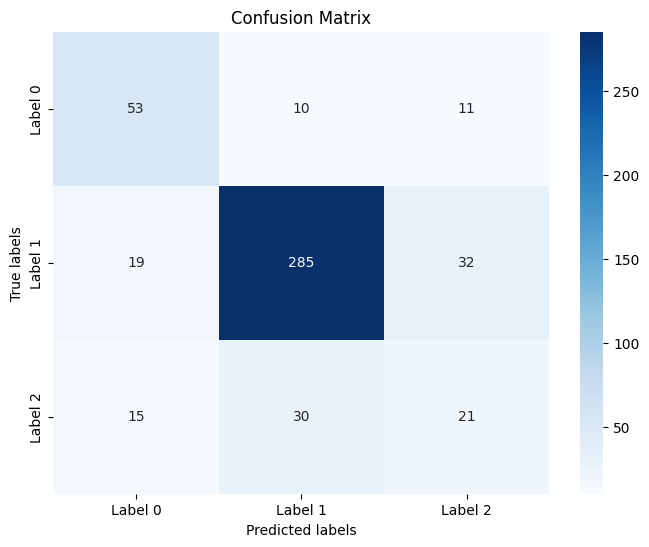

In [68]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [69]:
# Save the trained model
import pickle
import joblib

pickle_path = '/Users/binhtran/personal-projects/llm-data-aug/models/bertv1_pickle.pkl'
with open(pickle_path, 'wb') as file:
    pickle.dump(model, file)
    
joblib_path = '/Users/binhtran/personal-projects/llm-data-aug/models/bertv1_joblib.pkl'
joblib.dump(model, joblib_path)

['/Users/binhtran/personal-projects/llm-data-aug/models/bertv1_joblib.pkl']

In [71]:
# Save the trained model
model.save_pretrained('/Users/binhtran/personal-projects/llm-data-aug/models/fine_tuned_phobert_model')

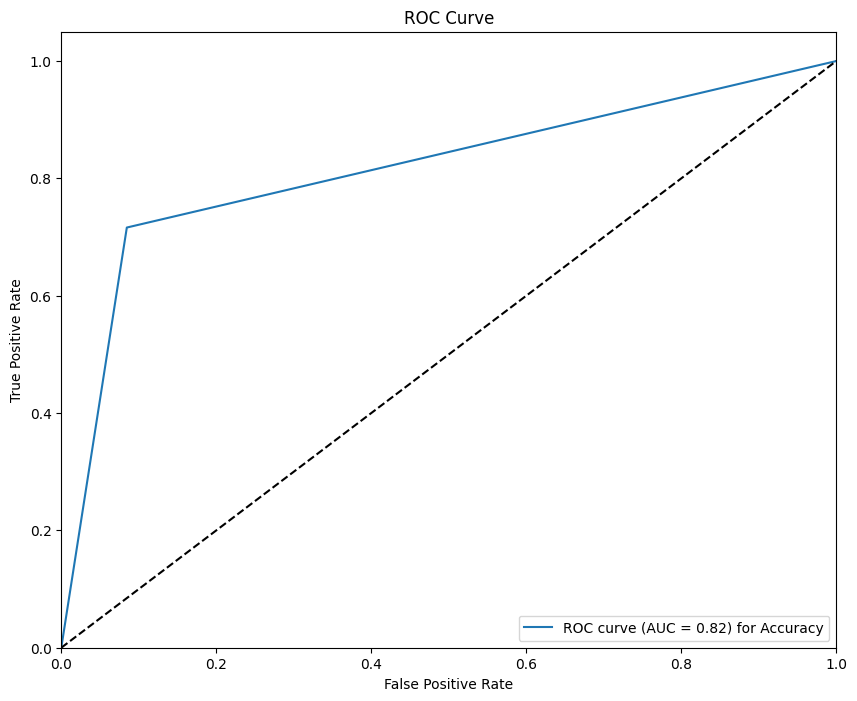

In [73]:
# Evaluation on test set and plot ROC curve
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Evaluation on test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate ROC Curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(len(target_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {target_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### PhoBERT V2

In [83]:
# Instantiate the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
# Define hyperparameters
batch_size = 32
max_length = 128
epochs = 5

In [85]:
# Create DataLoader for training and validation
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [88]:
# Move model to device
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_predictions / total_predictions

    print(f"Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1: 100%|██████████| 191/191 [01:04<00:00,  2.97it/s]


Epoch 1: Train Loss: 0.7070, Val Loss: 0.6195, Val Accuracy: 0.7638


Epoch 2: 100%|██████████| 191/191 [00:53<00:00,  3.57it/s]


Epoch 2: Train Loss: 0.5365, Val Loss: 0.5661, Val Accuracy: 0.7927


Epoch 3: 100%|██████████| 191/191 [00:53<00:00,  3.55it/s]


Epoch 3: Train Loss: 0.4412, Val Loss: 0.5906, Val Accuracy: 0.7900


Epoch 4: 100%|██████████| 191/191 [00:53<00:00,  3.58it/s]


Epoch 4: Train Loss: 0.4773, Val Loss: 0.6502, Val Accuracy: 0.7743


Epoch 5: 100%|██████████| 191/191 [00:53<00:00,  3.55it/s]


Epoch 5: Train Loss: 0.3848, Val Loss: 0.6371, Val Accuracy: 0.7900


Epoch 6: 100%|██████████| 191/191 [00:55<00:00,  3.46it/s]


Epoch 6: Train Loss: 0.2744, Val Loss: 0.6768, Val Accuracy: 0.7638


Epoch 7: 100%|██████████| 191/191 [01:09<00:00,  2.76it/s]


Epoch 7: Train Loss: 0.2045, Val Loss: 0.8151, Val Accuracy: 0.7822


Epoch 8: 100%|██████████| 191/191 [00:53<00:00,  3.54it/s]


Epoch 8: Train Loss: 0.1918, Val Loss: 0.8337, Val Accuracy: 0.7874


Epoch 9: 100%|██████████| 191/191 [00:53<00:00,  3.56it/s]


Epoch 9: Train Loss: 0.1770, Val Loss: 0.8839, Val Accuracy: 0.7664


Epoch 10: 100%|██████████| 191/191 [00:52<00:00,  3.62it/s]


Epoch 10: Train Loss: 0.1717, Val Loss: 0.8569, Val Accuracy: 0.7769


In [89]:
# Load test data
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [90]:
# Evaluation on test set
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.8299, Test Accuracy: 0.7752


In [91]:
# Evaluation on test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        _, predicted = torch.max(logits, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate classification report
target_names = ['Label 0', 'Label 1', 'Label 2']  # Specify label names
print(classification_report(true_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

     Label 0       0.68      0.72      0.70        74
     Label 1       0.87      0.88      0.88       336
     Label 2       0.33      0.29      0.31        66

    accuracy                           0.78       476
   macro avg       0.63      0.63      0.63       476
weighted avg       0.77      0.78      0.77       476



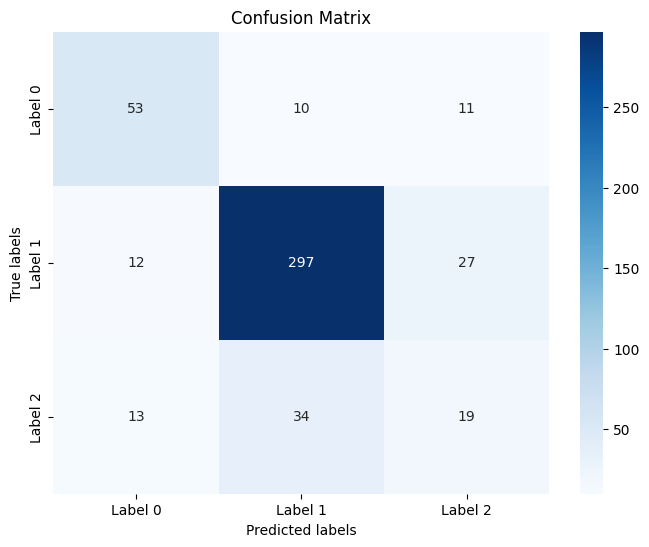

In [92]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [93]:
# Save the trained model

import pickle
import joblib

pickle_path = '/Users/binhtran/personal-projects/llm-data-aug/models/bertv2_pickle.pkl'
with open(pickle_path, 'wb') as file:
    pickle.dump(model, file)
joblib_path = '/Users/binhtran/personal-projects/llm-data-aug/models/bertv2_joblib.pkl'
joblib.dump(model, joblib_path)

['/Users/binhtran/personal-projects/llm-data-aug/models/bertv2_joblib.pkl']

In [95]:
# Save the trained model
model.save_pretrained('/Users/binhtran/personal-projects/llm-data-aug/models/fine_tuned_phobert_model v2')

### VISO BERT

In [ ]:
# Instantiate the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("uitnlp/visobert")
model = AutoModelForSequenceClassification.from_pretrained("uitnlp/visobert", num_labels=3)


In [ ]:
# Define hyperparameters
batch_size = 8
max_length = 128
epochs = 8

In [ ]:
# Create DataLoader for training and validation
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Evaluation
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_predictions / total_predictions

    print(f"Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


In [ ]:
# Load test data
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

# Evaluation on test set
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pickle
pickle_path = '/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/MODEL/visobert_pickle.pkl'
with open(pickle_path, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
import joblib
joblib_path = '/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/MODEL/visobert_joblib.pkl'
joblib.dump(model, joblib_path)

In [ ]:
# Save the trained model
model.save_pretrained('./fine_tuned_phobert_model viso')

##CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df['Sentiment'].replace({0: 'Positive', 1: 'Negative', 2: 'Neutral'}, inplace=True)

In [ ]:
label_mapping = {'Positive': 0, 'Neutral': 2, 'Negative': 1}

In [ ]:
# Tokenize the text and convert it to sequences of integers
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['emoji to text'])
X_sequences = tokenizer.texts_to_sequences(df['emoji to text'])

# Pad sequences to make them of the same length
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_sequences)

y_numerical = np.array([label_mapping[label] for label in df['Sentiment']])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_numerical, test_size=0.2, random_state=42)

# Build the model
cnnmodel = Sequential()
cnnmodel.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(64, activation='relu'))
cnnmodel.add(Dropout(0.5))
cnnmodel.add(Dense(len(label_mapping), activation='softmax'))  # Multi-class classification

cnnmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnnmodel.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the validation set
accuracy = cnnmodel.evaluate(X_val, y_val)[1]
print(f'CNN Model Accuracy: {accuracy}')

In [ ]:
import pickle
pickle_path = '/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/MODEL/cnn_pickle.pkl'
with open(pickle_path, 'wb') as file:
    pickle.dump(cnnmodel, file)

In [ ]:
import joblib
joblib_path = '/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/MODEL/cnn_joblib.pkl'
joblib.dump(cnnmodel, joblib_path)

### LSTM

In [ ]:
# Define the model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(len(label_mapping), activation='softmax'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the validation set
accuracy_lstm = lstm_model.evaluate(X_val, y_val)[1]
print(f'LSTM Model Accuracy: {accuracy_lstm}')

In [ ]:
joblib.dump(lstm_model,'/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/MODEL/lstm_model.pkl')

In [ ]:

# Đường dẫn tới file model trên Google Drive
model_path = '/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/MODEL/lstm_mpickle.pkl'

# Lưu mô hình LSTM sử dụng pickle trong một dòng
with open(model_path, 'wb') as file: pickle.dump(lstm_model, file)


### SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [ ]:
# Convert sequences back to text
X_train_text = tokenizer.sequences_to_texts(X_train)
X_val_text = tokenizer.sequences_to_texts(X_val)

# Build the SVC model with TF-IDF vectorization
svc_model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear'))])

# Train the SVC model
svc_model.fit(X_train_text, y_train)

# Predict and evaluate on the validation set
y_pred_svc = svc_model.predict(X_val_text)
accuracy_svc = accuracy_score(y_val, y_pred_svc)
print(f'SVC Model Accuracy: {accuracy_svc}')

In [ ]:
joblib.dump(svc_model,'/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/MODEL/svc_modeljob.pkl')

In [ ]:

# Đường dẫn tới file model trên Google Drive
model_path = '/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/MODEL/svc_mpickle.pkl'

# Lưu mô hình LSTM sử dụng pickle trong một dòng
with open(model_path, 'wb') as file: pickle.dump(svc_model, file)

### BERT-CNN

In [ ]:
!pip install transformers -qq
!pip install sentencepiece -qq
!pip install tokenizer -qq

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/train_data.csv')
dev = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/val_data.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PT HTTT NC/test_data.csv')
train['emoji to text'] = train['emoji to text'].astype(str)
X_train = train['emoji to text']
y_train = train["Sentiment"]
dev['emoji to text'] = dev['emoji to text'].astype(str)
X_valid = dev['emoji to text']
y_valid = dev['Sentiment']
test['emoji to text'] = test['emoji to text'].astype(str)
X_test = test['emoji to text']
y_test = test['Sentiment']

###Set cuda

In [ ]:
import torch
from torchtext import data
from torchtext import datasets
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

torch.cuda.is_available()

Extract feature by using PhoBERT

In [ ]:
import pandas as pd
from glob import glob

train_sentences = list(train['emoji to text'].values)
train_labels = list(train['Sentiment'].values)

dev_sentences = list(dev['emoji to text'].values)
dev_labels = list(dev['Sentiment'].values)

test_sentences = list(test['emoji to text'].values)
test_labels = list(test['Sentiment'].values)

Load tokenizer of PhoBERT

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')

In [ ]:
#choose max_length for phobert model based on the input length

max_length = 0
list_len=[]
for sentence in train_sentences:
    length = len(tokenizer.tokenize(sentence))
    list_len.append(length)

from collections import Counter
Counter(list_len).most_common(100)

In [ ]:
# Encode train label

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_labels)
encoded_labels = le.transform(train_labels)
encoded_test_labels = le.transform(dev_labels)

In [ ]:
# Tokens IDs tensor

def encoder_generator(sentences,labels):

    sent_index = []
    input_ids = []
    attention_masks =[]

    for index,sent in enumerate(sentences):

        sent_index.append(index)

        encoded_dict = tokenizer.encode_plus(sent,
                                             add_special_tokens=True,
                                             max_length=20,
                                             pad_to_max_length=True,
                                             truncation = True,
                                             return_attention_mask=True,
                                             return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids,dim=0).cuda()
    attention_masks = torch.cat(attention_masks,dim=0).cuda()
    labels = torch.tensor(labels).cuda()
    sent_index = torch.tensor(sent_index).cuda()

    return sent_index,input_ids,attention_masks,labels

train_sent_index,train_input_ids,train_attention_masks,train_encoded_label_tensors = encoder_generator(train_sentences,encoded_labels)
dev_sent_index,dev_input_ids,dev_attention_masks,dev_encoded_label_tensors = encoder_generator(dev_sentences,encoded_test_labels)
print('Original: ', train_sentences[0])
print('Token IDs:', train_input_ids[0])


In [ ]:
# Connvert train, dev input by using TensorDataset

from torch.utils.data import TensorDataset,random_split

train_dataset = TensorDataset(train_input_ids,train_attention_masks,train_encoded_label_tensors)
dev_dataset = TensorDataset(dev_input_ids,dev_attention_masks,dev_encoded_label_tensors)

print('train data samples is {}'.format(len(train_dataset)))
print("valid data samples is {}".format(len(dev_dataset)))

In [ ]:
# Set cuda by using device

from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

bs=128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_loader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=bs)
valid_data_loader = DataLoader(dev_dataset,
                              sampler=RandomSampler(dev_dataset),
                              batch_size=bs)


Load model PhoBERT

In [ ]:
from transformers import AutoModel

phoBert = AutoModel.from_pretrained('vinai/phobert-base')
phoBert = phoBert.to(device)

###CNN

In [ ]:
# Build class CNN

import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()

        self.fc_input = nn.Linear(embedding_dim,embedding_dim)

        self.conv_0 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[0])

        self.conv_1 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[1])

        self.conv_2 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[2])

        self.conv_3 = nn.Conv1d(in_channels = embedding_dim,
                                out_channels = n_filters,
                                kernel_size = filter_sizes[3])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, encoded):

        #embedded = [batch size, sent len, emb dim]
        embedded = self.fc_input(encoded)
        #print(embedded.shape)

        embedded = embedded.permute(0, 2, 1)
        #print(embedded.shape)

        #embedded = [batch size, emb dim, sent len]

        conved_0 = F.relu(self.conv_0(embedded))
        conved_1 = F.relu(self.conv_1(embedded))
        conved_2 = F.relu(self.conv_2(embedded))
        conved_3 = F.relu(self.conv_3(embedded))

        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        pooled_3 = F.max_pool1d(conved_3, conved_3.shape[2]).squeeze(2)

        #pooled_n = [batch size, n_fibatlters]

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2, pooled_3), dim = 1).cuda())

        #cat = [batch size, n_filters * len(filter_sizes)]

        result =  self.fc(cat)

        #print(result.shape)

        return result

In [ ]:
# Hyperparameters

EMBEDDING_DIM = 768
N_FILTERS = 32
FILTER_SIZES = [1,2,3,5]
OUTPUT_DIM = len(le.classes_)
DROPOUT = 0.1
PAD_IDX = tokenizer.pad_token_id

cnn = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
cnn = cnn.to(device)

In [ ]:
# Optimizer and criterion

import torch.optim as optim

model_prameters = list(phoBert.parameters())+list(cnn.parameters())

optimizer = optim.Adam(model_prameters,lr=2e-5,eps=1e-8)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
# Calculate accuracy per batch during train

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).cuda()


In [ ]:
# Def for training

from tqdm import tqdm

def train():

    epoch_loss = 0
    epoch_acc = 0

    phoBert.train()
    cnn.train()

    for batch in tqdm(train_data_loader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()

        embedded = phoBert(b_input_ids,b_input_mask)[0]

        predictions = cnn(embedded)

        loss = criterion(predictions, b_labels)

        acc = categorical_accuracy(predictions, b_labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_data_loader), epoch_acc / len(train_data_loader)


In [ ]:
# Class for predict label

import numpy as np

def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

In [ ]:
# Evaluate loss, acc  and f1-macro

from sklearn.metrics import classification_report,accuracy_score,f1_score
def eval():
    epoch_loss = 0

    total_predictions = []
    total_true = []

    all_true_labels = []
    all_pred_labels = []

    phoBert.eval()
    cnn.eval()

    with torch.no_grad():

        for batch in tqdm(valid_data_loader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            embedded = phoBert(b_input_ids,b_input_mask)[0]
            predictions = cnn(embedded)

            loss = criterion(predictions, b_labels)
            epoch_loss += loss.item()

            predictions = predictions.detach().cpu().numpy()

            label_ids = b_labels.to('cpu').numpy()

            pred,true = predictions_labels(predictions,label_ids)

            all_pred_labels.extend(pred)
            all_true_labels.extend(true)

    print(classification_report(all_pred_labels,all_true_labels))
    avg_val_accuracy = accuracy_score(all_pred_labels,all_true_labels)
    macro_f1_score = f1_score(all_pred_labels,all_true_labels,average='macro')

    avg_val_loss = epoch_loss/len(valid_data_loader)

    print("accuracy = {0:.2f}".format(avg_val_accuracy))

    return avg_val_loss,avg_val_accuracy,macro_f1_score

In [ ]:
# Time for training

import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
# Set device and gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

phoBert.cuda()


###Traning

In [ ]:
epochs = 10

best_macro_f1 = float('0')

for epoch in range(epochs):

    start_time = time.time()
    train_loss,train_acc = train()
    valid_loss,valid_acc,macro_f1 = eval()
    end_time = time.time()


    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        torch.save(phoBert,'/content/phobert_cnn_model_part1_'+'task2a_2.pt')
        torch.save(cnn,'/content/phobert_cnn_model_part2_'+'task2a_2.pt')
        print("model saved")

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. acc: {valid_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {macro_f1*100:.2f}%')
    print('=============Epoch Ended==============')

###Evaluating

In [ ]:
# Save PhoBERT and CNN
torch.save(phoBert,'module2_part1.pt')
torch.save(cnn,'module2_part2.pt')

In [ ]:
# Load phobert and cnn
import torch
phoBert = torch.load(r'/content/phobert_cnn_model_part1_task2a_2.pt')
cnn = torch.load(r'/content/phobert_cnn_model_part2_task2a_2.pt')
phoBert.eval()
cnn.eval()

In [ ]:
test_sent_index, test_input_ids, test_attention_masks, test_encoded_label_tensors = encoder_generator(test_sentences,test_labels)
test_dataset = TensorDataset(test_input_ids,test_attention_masks,test_encoded_label_tensors)

test_data_loader = DataLoader(test_dataset,
                              sampler=RandomSampler(test_dataset),
                              batch_size=bs)

all_pred_labels = []
all_true_labels = []

with torch.no_grad():
  for batch in tqdm(test_data_loader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    embedded = phoBert(b_input_ids,b_input_mask)[0]
    predictions = cnn(embedded)


    predictions = predictions.detach().cpu().numpy()

    label_ids = b_labels.to('cpu').numpy()

    pred, true = predictions_labels(predictions, label_ids)

    all_pred_labels.extend(pred)
    all_true_labels.extend(true)


In [ ]:
# The final score in the test set (classification report)

print(classification_report(all_pred_labels,all_true_labels, digits = 4))

#Streaming


In [ ]:
# Hàm normalize_repeated_words
def normalize_repeated_words(text):
    # Sử dụng biểu thức chính quy để tìm và thay thế các từ viết kéo dài
    normalized_text = re.sub(r'(\w)(\1{2,})', r'\1', text)
    return normalized_text

# Hàm remove_non_alphanumeric
def remove_non_alphanumeric(string):
    allowed_characters = r'[^\w\sA-Za-zÀÁẮẤẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴa-z0-9.,\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF.]+'
    return re.sub(allowed_characters, '', string)

# Hàm xử lý các ký tự đặc biệt
def remove_special_characters(text):
    special_characters = r'[\x00-\x1F\x7F' + \
                         r'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' + \
                         r'¢£¥€©®™“”‘’–\/‒—ñàáâäçßæøÿ]'
    clean_text = re.sub(r'\.\.\.', '...', str(text))
    clean_text = re.sub(special_characters, '', clean_text)
    return clean_text

# Hàm build_dictionary_from_file
def build_dictionary_from_file(file_path):
    abbreviation_dict = {}

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split(',')
                if len(parts) == 2:
                    abbreviation, full_form = map(str.strip, parts)
                    abbreviation_dict[abbreviation] = full_form

    return abbreviation_dict

# Function to expand abbreviations in a given text
def expand_abbr(text, abbr_dict):
    return ' '.join(abbr_dict.get(word, word) for word in text.split())

# Đường dẫn đến tệp chứa danh sách các từ viết tắt và định nghĩa tương ứng
abbreviations_path = ("/content/drive/MyDrive/PT HTTT NC/DICT/abbreviate.txt")
abbr = build_dictionary_from_file(abbreviations_path)

# Initialize VnCoreNLP
vncorenlp_path = '/content/VnCoreNLP/VnCoreNLP-1.1.1.jar'  # Thay đường dẫn đến VnCoreNLP.jar tại đây
vncorenlp = VnCoreNLP(vncorenlp_path)

# Tokenize text in each row of the DataFrame
def tokenize_text(text):
    tokens = vncorenlp.tokenize(text)
    return ' '.join(' '.join(sentence) for sentence in tokens)

In [ ]:
def expand_abbr(text, abbr_dict):
    text = expand_abbr(text, abbr_dict)
    text = sent_tokenize(text)
    text = ' '.join(text)
    text = word_tokenize(text, format="text")
    text = text_normalize(text)
    text = ev.demojize(text)
    text = re.sub(r'(:\w+:)', r',\1,', text)
    text = remove_non_alphanumeric(text)
    return text

In [ ]:
def predict_sentiment(text):
    abbr_dict = build_dictionary_from_file(abbreviations_path)

    # Tiền xử lý văn bản mới
    processed_text = preprocess_text(text, abbr_dict)
    print("Preprocessed Text:", processed_text)

    # Sử dụng tokenizer để mã hóa và chuyển đổi văn bản thành tensor
    sent_index, input_ids, attention_masks, _ = encoder_generator([processed_text], [0])

    # Đưa tensor vào mô hình để dự đoán
    phoBert.eval()
    cnn.eval()
    with torch.no_grad():
        embedded = phoBert(input_ids, attention_masks)[0]
        predictions = cnn(embedded)

    # Xử lý kết quả dự đoán
    sentiment_labels = ["Negative", "Positive", "Neutral"]
    pred_index = torch.argmax(predictions, dim=1).item()
    sentiment = sentiment_labels[pred_index]
    confidence = torch.max(torch.softmax(predictions, dim=1)).item()

    return sentiment, confidence

# Sử dụng hàm để dự đoán cảm xúc cho một đoạn văn bản mới


In [ ]:
input_text = input("Enter the review: ")
sentiment, confidence = predict_sentiment(input_text)
print("Sentiment:", sentiment)
print("Confidence:", confidence)


In [ ]:
def expand_abbr(text, abbr_dict):
    # Add a base case to prevent infinite recursion
    if text not in abbr_dict:
        return text

    expanded_text = ' '.join(abbr_dict.get(word, word) for word in text.split())
    return expand_abbr(expanded_text, abbr_dict)